# Импорт

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from LookGenerator.datasets.person_segmantation_dataset import PersonSegmentationDataset, PersonSegmentationDatasetMultichannel
from LookGenerator.networks.segmentation import UNet, train_unet
from LookGenerator.networks.utils import load_model
import LookGenerator.datasets.transforms as custom_transforms
from LookGenerator.datasets.utils import prepare_image_for_model_transpose, to_array_from_model_transpose, show_array_multichannel
from LookGenerator.datasets.utils import prepare_image_for_model_transpose, to_array_from_model_bin_transpose


# Загрузка данных

In [2]:
transform_input = transforms.Compose([
    transforms.Resize((256, 192)),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.25, 0.25, 0.25]
    )
])

transform_output = transforms.Compose([
    transforms.Resize((256, 192)),
    custom_transforms.MinMaxScale(),
    custom_transforms.ThresholdTransform(threshold=0.5)
])

In [3]:
batch_size_train = 24
batch_size_val = 12

In [4]:
train_dataset = PersonSegmentationDataset("C:\\Users\\DenisovDmitrii\\Desktop\\train", transform_input=transform_input, transform_mask=transform_output)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
len(train_dataloader)

123

In [5]:
val_dataset = PersonSegmentationDataset("C:\\Users\\DenisovDmitrii\\Desktop\\test", transform_input=transform_input, transform_mask=transform_output)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False)
len(val_dataloader)

78

Test load train_dataloader. and val.

torch.Size([24, 3, 256, 192])
torch.Size([24, 1, 256, 192])


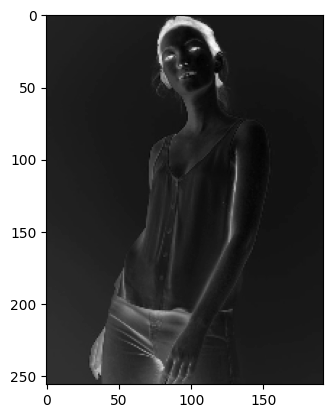

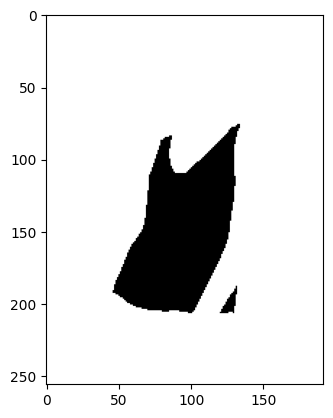

In [6]:
for X, y in train_dataloader:
    print(X.shape)
    print(y.shape)
    plt.imshow(X.detach().numpy()[0,0,:,:], cmap = 'binary')
    plt.show()
    plt.imshow(y.detach().numpy()[0,0,:,:], cmap = 'binary')
    plt.show()
    # modelled_img = to_array_from_model_bin_transpose(transform_output(X.detach()))
    # plt.imshow(modelled_img,cmap = 'binary')
    # plt.show()
    # modelled_img = to_array_from_model_bin_transpose(transform_output(y.detach()))
    # plt.imshow(modelled_img,cmap = 'binary')
    # plt.show()
    break

# Обучение модели

Метки классов на изображении:

1. Левое лицо                       248,251,14
2. Правое лицо                      251,235,25
3. Туловище                         20,80,194
4. Внешняя верхняя левая рука       190,189,96
5. Внешняя верхняя правая рука      215,187,88
6. Внешняя нижняя левая рука        252,206,48
7. Внешняя нижняя правая рука       250,220,36
8. Внутренняя верхняя левая рука    145,191,116
9. Внутренняя верхняя правая рука   170,190,105
10. Внетренняя нижняя левая рука     228,191,74
11. Внутренняя нижняя правая рука    240,198,60
12. Левая кисть                      8,110,221
13. Правая кисть                     4,98,224
14. Левая нога                       22,173,184
15. Правая нога                      6,166,198

In [7]:
model = UNet(in_channels=3, out_channels = 1)
#model = load_model(model, r'C:\Users\DenisovDmitrii\Desktop\segmentation_weits\session12\asd.pt')
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [8]:
import datetime
now = datetime.datetime.now()
print("start time", now.strftime("%d-%m-%Y %H:%M"))

train_history, val_history = train_unet(
    model,
    train_dataloader,
    val_dataloader,
    optimizer,
    device=device,
    epoch_num=20,
    save_directory="C:\\Users\\DenisovDmitrii\\Desktop\\segmentation_weits\\session28"
)
old = now
now = datetime.datetime.now()
print("end time", now.strftime("%d-%m-%Y %H:%M"))
print("delta", now - old)


start time 26-02-2023 22:37
Epoch 0 of 19, train loss: 0.01715
Epoch 0 of 19, val loss: 0.00578
Epoch 1 of 19, train loss: 0.00286
Epoch 1 of 19, val loss: 0.00286
Epoch 2 of 19, train loss: 0.00121
Epoch 2 of 19, val loss: 0.00091
Epoch 3 of 19, train loss: 0.00090
Epoch 3 of 19, val loss: 0.00065
Epoch 4 of 19, train loss: 0.00058
Epoch 4 of 19, val loss: 0.00033
Epoch 5 of 19, train loss: 0.00035
Epoch 5 of 19, val loss: 0.00041
Epoch 6 of 19, train loss: 0.00026
Epoch 6 of 19, val loss: 0.00024
Epoch 7 of 19, train loss: 0.00022
Epoch 7 of 19, val loss: 0.00139
Epoch 8 of 19, train loss: 0.00026
Epoch 8 of 19, val loss: 0.00017
Epoch 9 of 19, train loss: 0.00018
Epoch 9 of 19, val loss: 0.09094
Epoch 10 of 19, train loss: 0.00019
Epoch 10 of 19, val loss: 0.00065
Epoch 11 of 19, train loss: 0.00013
Epoch 11 of 19, val loss: 0.00016
Epoch 12 of 19, train loss: 0.00010
Epoch 12 of 19, val loss: 0.00012
Epoch 13 of 19, train loss: 0.00009
Epoch 13 of 19, val loss: 0.00015
Epoch 14 of 

In [ ]:
model = load_model(model, r'C:\Users\Даша\PycharmProjects\SMBackEnd\LookGenerator\weights\unet_epoch_0_0.0161572862694324.pt')
model.eval()